In [1]:
import tensorflow as tf
import numpy as np
from model import bioRNN
from training import supervised_train_step
from stp_stimulus import Stimulus
import matplotlib.pyplot as plt
from IPython.display import HTML

--> Loading parameters...
--> Parameters successfully loaded.



In [2]:
# Choose GPU
gpu_idx = 3
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpu_idx], 'GPU')

In [3]:
class NestedDMS:
    def __init__(self, n_dirs=8, n_motion_tuned=32, n_fix_tuned=4,
                 tuning_height=4, n_subtasks=2, stim_len=20, delay_len=20,
                 decision_len=20, gap_len=10, batch_size=64):
        self.__dict__.update(locals())
        self.pref_motion_dirs = np.reshape(np.linspace(0,2*np.pi-2*np.pi/(self.n_motion_tuned), \
            (self.n_motion_tuned)), (self.n_motion_tuned,1))
        self.motion_dirs = np.linspace(0,2*np.pi-2*np.pi/self.n_dirs,self.n_dirs)
        self.trial_len = n_subtasks*(stim_len+decision_len+2*gap_len) + delay_len
        self.input_size = self.n_motion_tuned+self.n_fix_tuned
        self.output_size = 3

    def circ_tuning(self, theta):
        ang_dist = np.angle(np.exp(1j*theta - 1j*self.pref_motion_dirs))
        return self.tuning_height*np.exp(-0.5*(8*ang_dist/np.pi)**2)

    def generate_trial(self, batch_size=None):
        if batch_size == None: batch_size = self.batch_size

        # Prep inputs, labels
        inputs = np.zeros([self.trial_len, batch_size, self.input_size])
        labels = np.zeros([self.trial_len, batch_size, self.output_size])

        # By default, set inputs & labels to fixate
        inputs[:, :, -self.n_fix_tuned:] = self.tuning_height
        labels[:,:,-1] = 1.

        # Get stim, test dirs and match labels (idxed by task idx)
        match = np.random.choice([0,1], size=[batch_size,self.n_subtasks])
        sample_dir = np.random.choice(self.motion_dirs, size=[batch_size,self.n_subtasks])
        test_dir = np.zeros_like(sample_dir)
        for b in range(batch_size):
            for s in range(self.n_subtasks):
                this_sample_dir = sample_dir[b,s]
                this_sample_dir_idx = np.where(self.motion_dirs == this_sample_dir)[0]

                # If non-match, sample randomly from other directions
                if match[b,s] == 0:
                    this_test_dir = np.random.choice(np.setdiff1d(self.motion_dirs, self.motion_dirs[this_sample_dir_idx]))
                else:
                    this_test_dir = this_sample_dir
                test_dir[b,s] = this_test_dir
        subtask_labels = (sample_dir == test_dir).astype(np.int32) # (B, self.n_subtasks)

        # Fill inputs with motion stimulus
        for i in range(self.n_subtasks):
            # Get sample, test inputs
            sample_input = self.circ_tuning(sample_dir[:,i]).T # (B,n_motion_tuned)
            sample_input = np.expand_dims(sample_input, axis=0) # (1,B,n_motion_tuned)
            test_input = self.circ_tuning(test_dir[:,i]).T # (B,n_motion_tuned)
            test_input = np.expand_dims(test_input, axis=0) # (1,B,n_motion_tuned)

            # Fill sample part
            subtask_start_t = i*(self.gap_len + self.stim_len)
            sample_start_t = subtask_start_t + self.gap_len
            sample_end_t = subtask_end_t = (sample_start_t + self.stim_len)
            inputs[sample_start_t:sample_end_t, :, :self.n_motion_tuned] = sample_input

            # Fill test part
            inputs[-sample_end_t:-sample_start_t, :, :self.n_motion_tuned] = test_input
            inputs[-sample_end_t:-sample_start_t, :, -self.n_fix_tuned:] = 0.
            labels[-sample_end_t:-sample_start_t, :, -1] = 0.
            for b in range(batch_size):
                labels[-sample_end_t:-sample_start_t, b, subtask_labels[b,i]] = 1.

        return inputs.astype(np.float32), labels.astype(np.float32), \
            sample_dir.astype(np.float32), test_dir.astype(np.float32)

In [4]:
# Data generator
stim = NestedDMS()
inputs, labels, sample_dir, test_dir = stim.generate_trial()

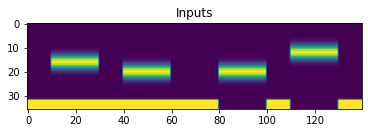

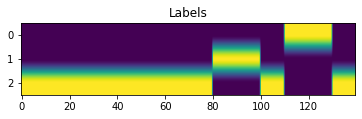

In [5]:
b = np.random.randint(inputs.shape[1])

# Inputs
plt.imshow(inputs[:,b,:].T)
plt.title('Inputs')
plt.show()

# Labels
plt.imshow(labels[:,b,:].T, aspect=10.0)
plt.title('Labels')
plt.show()

In [6]:
# Model hyper-params
hidden_size = 512
output_size = labels.shape[-1]
synapse_config = 'full'

# Optimization hyper-params
learning_rate = 1e-2
n_iterations = 3000

In [7]:
# Define a model
rnn = bioRNN(hidden_size, output_size, synapse_config=synapse_config)
opt = tf.keras.optimizers.Adam(learning_rate=float(learning_rate))

In [8]:
# Train the model
loss_list = []
acc_list = []
print('\n=== TRAINING === \n')
for i in range(n_iterations):
    inputs, labels, sample_dir, test_dir = stim.generate_trial()
    metrics = supervised_train_step(rnn, opt, inputs, labels)
    loss = round(float(metrics['loss']), 2)
    acc = round(float(metrics['argmax_accuracy']), 2)
    dec_acc = round(float(metrics['decision_accuracy']), 2)
    fix_acc = round(float(metrics['fixation_accuracy']), 2)
    loss_list.append(loss)
    acc_list.append(acc)
    if i%100==0:
        print(f'Iter: {i} | Loss: {loss} | Acc: {acc} | Fixation Acc: {fix_acc} | Decision Acc: {dec_acc}')


=== TRAINING === 

Iter: 0 | Loss: 3.64 | Acc: 0.66 | Fixation Acc: 0.92 | Decision Acc: 0.0
Iter: 100 | Loss: 0.22 | Acc: 0.85 | Fixation Acc: 1.0 | Decision Acc: 0.49
Iter: 200 | Loss: 0.21 | Acc: 0.85 | Fixation Acc: 1.0 | Decision Acc: 0.49
Iter: 300 | Loss: 0.21 | Acc: 0.85 | Fixation Acc: 1.0 | Decision Acc: 0.48
Iter: 400 | Loss: 0.2 | Acc: 0.86 | Fixation Acc: 1.0 | Decision Acc: 0.52
Iter: 500 | Loss: 0.2 | Acc: 0.85 | Fixation Acc: 1.0 | Decision Acc: 0.47
Iter: 600 | Loss: 0.18 | Acc: 0.89 | Fixation Acc: 1.0 | Decision Acc: 0.61
Iter: 700 | Loss: 0.18 | Acc: 0.91 | Fixation Acc: 1.0 | Decision Acc: 0.68
Iter: 800 | Loss: 0.15 | Acc: 0.93 | Fixation Acc: 1.0 | Decision Acc: 0.74
Iter: 900 | Loss: 0.13 | Acc: 0.95 | Fixation Acc: 1.0 | Decision Acc: 0.82
Iter: 1000 | Loss: 0.14 | Acc: 0.94 | Fixation Acc: 1.0 | Decision Acc: 0.8
Iter: 1100 | Loss: 0.13 | Acc: 0.95 | Fixation Acc: 1.0 | Decision Acc: 0.83
Iter: 1200 | Loss: 0.11 | Acc: 0.96 | Fixation Acc: 1.0 | Decision Acc:

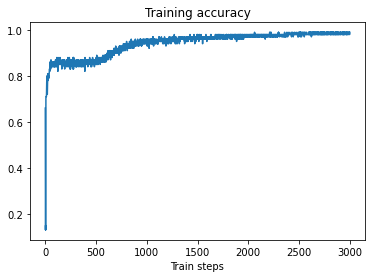

In [12]:
# Plot accuracies
plt.plot(acc_list)
plt.title('Training accuracy')
plt.xlabel('Train steps')
plt.show()

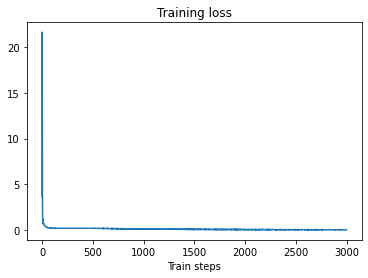

In [13]:
# Plot loss
plt.plot(loss_list)
plt.title('Training loss')
plt.xlabel('Train steps')
plt.show()

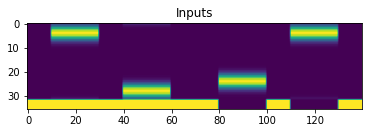

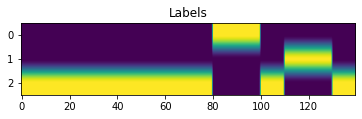

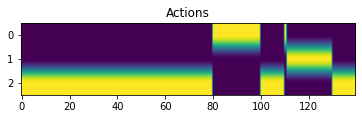

In [11]:
# Look at an example trial with the model's actions
inputs, labels, sample_dir, test_dir = stim.generate_trial()
results = rnn.do_trial(inputs)
action_idxs = tf.math.argmax(results['outputs'], axis=-1) # (T, B)
actions = tf.one_hot(action_idxs, output_size)

b = np.random.randint(inputs.shape[1])

# Inputs
plt.imshow(inputs[:,b,:].T)
plt.title('Inputs')
plt.show()

# Labels
plt.imshow(labels[:,b,:].T, aspect=10.0)
plt.title('Labels')
plt.show()

# Actions
plt.imshow(actions[:,b,:].numpy().T, aspect=10.0)
plt.title('Actions')
plt.show()